In [1]:
import os
import sys

NJET_BLHA='/Users/simon/packages/njet-3.1.1-1L/blha/'
sys.path.append(NJET_BLHA)

import numpy as np
from pstools.rambo import generate, dot
from njettools.njet_interface import *
from nntools.model import Model

Using TensorFlow backend.


# Setup in NJet interface to ee->3j amplitudes #

In [2]:
# set a BLHA file to provide squared amplitudes via NJet
contract_file = 'NJ_contract_ee3j_tree.lh'

In [3]:
# choose the number of training points (will later be split into NN train/test set)
n_training_points = 10000
delta_cut = 0.03

In [4]:
# generate 2 -> 3 phase-space points for training
momenta, n_trials = generate(3, n_training_points, rts=1000., delta=delta_cut)
momenta = momenta.tolist()

100%|██████████| 10000/10000 [00:01<00:00, 5421.28it/s]


In [5]:
n_legs = len(momenta[0])
print(n_legs, n_training_points, n_training_points/n_trials)

5 10000 0.8276775368316504


In [6]:
# check phase-space point satisfies momentum conservation
p = momenta[0]
-p[0]-p[1]+p[2]+p[3]+p[4]

array([ 5.68434189e-14, -5.68434189e-14, -5.68434189e-14,  0.00000000e+00])

In [7]:
# start the NJet interface
olp = njet.OLP()
status = njet_init(contract_file)

if status == True:
    print ("OLP read in correctly")
else:
    print ("seems to be a problem with the contract file...")

OLP read in correctly


In [8]:
mur = 100.
alphas = 0.118
alpha = 1/137.

In [9]:
# demonstrating the evaluation of tree-level matrix element squared
testval0 = olp.OLP_EvalSubProcess(1,
                       momenta[0],
                       alphas=alphas,
                       alpha=alpha,
                       mur=mur,
                       retlen=1)

print(testval0)

testval1 = olp.OLP_EvalSubProcess(1,
                       momenta[1],
                       alphas=alphas,
                       alpha=alpha,
                       mur=mur,
                       retlen=1)

print(testval1)

[0.008000057866404488]
[0.018200397338367407]


In [10]:
# checking against analytic formula
# a,b -> 1q,2qb,3g

def amp0sq(alphas, p):
    # match some (not very sensible) conventions in NJet
    norm = (16*np.pi)**3/16
    
    Qu = 2/3 # fractional quark charge
    Nc = 3
    CF = (Nc**2-1)/(2.*Nc)

    sab=2*dot(p[0],p[1])
    s12=2*dot(p[2],p[3])
    s13=2*dot(p[2],p[4])
    s23=2*dot(p[3],p[4])

    s1a=-2*dot(p[2],p[0])
    s1b=-2*dot(p[2],p[1])
    s2a=-2*dot(p[3],p[0])
    s2b=-2*dot(p[3],p[1])

    amp0sq = Qu**2*norm*alphas*CF*Nc*(s1a**2+s1b**2+s2a**2+s2b**2)/(sab*s13*s23)
    return amp0sq

In [11]:
print("|A|^2  =", amp0sq(alphas, momenta[0]))
print("ratio = ", amp0sq(alphas, momenta[0])/testval0[0])

print("|A|^2  =", amp0sq(alphas, momenta[1]))
print("ratio = ", amp0sq(alphas, momenta[1])/testval1[0])

|A|^2  = 0.008000057866404417
ratio =  0.9999999999999911
|A|^2  = 0.018200397338367615
ratio =  1.0000000000000115


In [12]:
NJ_treevals = [];
for pt in range(n_training_points):
    vals = olp.OLP_EvalSubProcess(1, momenta[pt], alphas=alphas, alpha=alpha, mur=mur, retlen=1)
    NJ_treevals.append(vals[0])

In [13]:
# dump generated data in case NJet and interface not available
np.save("NJ_ee3j_tree_momenta.npy", momenta)
np.save("NJ_ee3j_tree_values.npy", NJ_treevals)
n_training_points = len(momenta)

# Train NN with amplitude data #

In [14]:
momenta = np.load("NJ_ee3j_tree_momenta.npy")
NJ_treevals = np.load("NJ_ee3j_tree_values.npy")

In [15]:
NN = Model(
    5*4, # train with all momenta components 
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals) # data points from NJet evaluations
)

In [16]:
model, x_mean, x_std, y_mean, y_std = NN.fit(layers=[16,32,16])

processing training data using scaling =  standardise
The training dataset has size (8000, 20)
Epoch 1/10000
8000/8000 [==============================] - 1s 108us/sample - loss: 0.8751 - val_loss: 0.5938


In [17]:
testmoms = momenta

In [18]:
x_standardized = NN.process_testing_data(moms=testmoms,
                                         x_mean=x_mean,
                                         x_std=x_std,
                                         y_mean=y_mean,
                                         y_std=y_std)

In [19]:
mpred = model.predict(x_standardized)

In [20]:
amp_pred = NN.destandardise_data(mpred.reshape(-1),x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

In [21]:
diff = (amp_pred-np.array(NJ_treevals))/(amp_pred+np.array(NJ_treevals))

In [22]:
np.average(diff)

-0.01555590527332054

In [23]:
max(diff)

0.2350851543436455

In [24]:
min(diff)

-0.2906947238946178

In [25]:
np.median(diff)

-0.009070907620416464

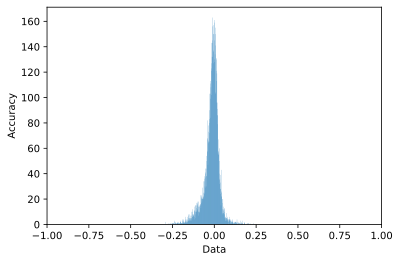

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(diff, density=False, bins=500)
plt.xlim([-1,1])
plt.ylabel('Accuracy')
plt.xlabel('Data');

# test trained network #

In [27]:
n_points = 50000
newmomenta, n_trials2 = generate(3, n_points, rts=1000., delta=delta_cut)
newmomenta = newmomenta.tolist()

100%|██████████| 50000/50000 [00:09<00:00, 5322.22it/s]


In [28]:
NJ_treevals_test = [];
for pt in range(n_points):
    vals = olp.OLP_EvalSubProcess(1, newmomenta[pt], alphas=alphas,alpha=alpha,mur=mur, retlen=1)
    NJ_treevals_test.append(vals[0])

In [29]:
x_standardized = NN.process_testing_data(moms=newmomenta,x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

mpred = model.predict(x_standardized)

amp_pred = NN.destandardise_data(mpred.reshape(-1),x_mean=x_mean,x_std=x_std,y_mean=y_mean,y_std=y_std)

diff = (amp_pred-np.array(NJ_treevals_test))/(amp_pred+np.array(NJ_treevals_test))

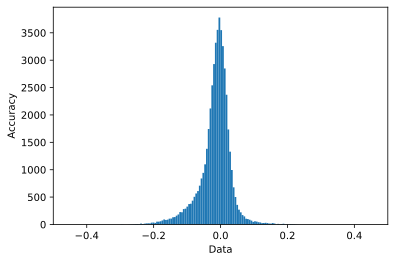

In [30]:
plt.hist(diff, density=False, bins=100)
plt.xlim([-0.5,0.5])
plt.ylabel('Accuracy')
plt.xlabel('Data');

In [31]:
logdiff = np.log10(abs(diff))

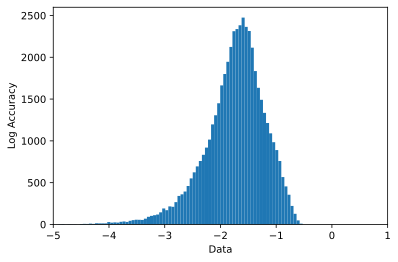

In [32]:
plt.hist(logdiff, density=False, bins=100)
plt.xlim([-5,1])
plt.ylabel('Log Accuracy')
plt.xlabel('Data');

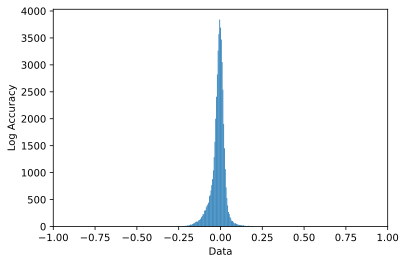

In [33]:
logratio = np.log10(amp_pred/np.array(NJ_treevals_test))
plt.hist(logratio, density=False, bins=100)
plt.xlim([-1,1])
plt.ylabel('Log Accuracy')
plt.xlabel('Data');

# cross-section check #

In [34]:
np.mean(NJ_treevals_test), np.std(NJ_treevals_test)*np.mean(NJ_treevals_test)

(0.03665583044206242, 0.0032453907176464595)

In [35]:
np.mean(amp_pred), np.std(amp_pred)*np.mean(amp_pred)

(0.0363658, 0.003168277)

In [36]:
xs_NJ = []
xs_NN = []
for i in range(1,n_points):
    xs_NJ.append([np.mean(NJ_treevals_test[0:i]), np.std(NJ_treevals_test[0:i])])
    xs_NN.append([np.mean(amp_pred[0:i]), np.std(amp_pred[0:i])])

xs_NJ = np.array(xs_NJ)
xs_NN = np.array(xs_NN)

In [37]:
plotdata1 = xs_NJ[0::100,0]
len(plotdata1)

500

In [38]:
plotdata2 = xs_NN[0::100,0]
len(plotdata2)

500

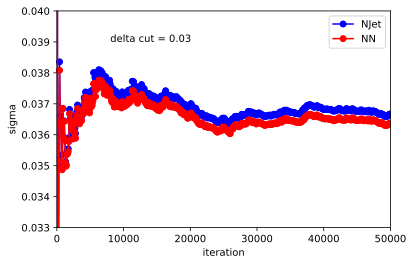

In [47]:
plt.plot(100*np.array(range(len(plotdata1))), plotdata1, 'b-o', label='NJet')
plt.plot(100*np.array(range(len(plotdata2))), plotdata2, 'r-o', label='NN')
plt.xlim([0,n_points])
plt.ylim([0.033,0.04])
plt.ylabel('sigma')
plt.xlabel('iteration');
plt.text(8000,0.039,'delta cut = '+str(delta_cut))
plt.legend()